In [1]:
# 1. Installing and Importing Necessary Libraries ####
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.stats.weightstats import ztest

# Set working directory
os.chdir("D:/Masters/VCU/Classes/SCMA/R/A1")

In [2]:
# 2. Reading the data set into Python ####
data = pd.read_csv("../A1/Ref/NSSO68.csv", low_memory=False)

In [3]:
# 3. Filtering data for a specific state and writing the file to a path ####
state_name = "KA"
state_data = data[data['state_1'] == state_name].copy()
state_data.to_csv('../A1/Ref/state_filtered_data.csv', index=False)

In [4]:
# 4. Display dataset information ####
print("Dataset Information:")
print(state_data.columns)
print(state_data.head())
print("Dimensions:", state_data.shape)
print("Missing Values:", state_data.isnull().sum())

Dataset Information:
Index(['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number',
       'Sample', 'Sector', 'state', 'State_Region',
       ...
       'pickle_v', 'sauce_jam_v', 'Othrprocessed_v', 'Beveragestotal_v',
       'foodtotal_v', 'foodtotal_q', 'state_1', 'Region', 'fruits_df_tt_v',
       'fv_tot'],
      dtype='object', length=384)
        slno       grp  Round_Centre  FSU_number  Round  Schedule_Number  \
23109  23110  4.61E+31             1       46141     68               10   
23110  23111  4.61E+31             1       46141     68               10   
23111  23112  4.61E+31             1       46141     68               10   
23112  23113  4.61E+31             1       46141     68               10   
23113  23114  4.61E+31             1       46141     68               10   

       Sample  Sector  state  State_Region  ...  pickle_v  sauce_jam_v  \
23109       1       2     29           294  ...  0.003571          0.0   
23110       1       2     29  

In [5]:
# 5. Check for missing values ####
missing_info = state_data.isnull().sum()
print("Missing Values Information:\n", missing_info)

Missing Values Information:
 slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


In [6]:
# 6. Select relevant columns for analysis ####
columns_to_keep = [
    'state_1', 'District', 'Region', 'Sector', 'State_Region',
    'Meals_At_Home', 'ricetotal_v', 'wheattotal_v', 'Milktotal_v',
    'pulsestot_v', 'chicken_v', 'No_of_Meals_per_day'
]
state_subset = state_data[columns_to_keep].copy()

In [7]:
# 7. Impute missing values with mean ####
state_subset['Meals_At_Home'] = state_subset['Meals_At_Home'].fillna(
    state_subset['Meals_At_Home'].mean()
)

In [8]:
# 8. Remove outliers from specific columns ####
def remove_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.where((series >= lower) & (series <= upper))

boxplot_columns = [
    "Meals_At_Home", "ricetotal_v", "wheattotal_v",
    "Milktotal_v", "pulsestot_v", "chicken_v", "No_of_Meals_per_day"
]

state_subset_plot = state_subset.copy()
for col in boxplot_columns:
    state_subset_plot[col] = remove_outliers(state_subset_plot[col])

In [9]:
# 9. Create total consumption variable ####
state_subset['total_consumption'] = state_subset[
    ['ricetotal_v', 'wheattotal_v', 'Milktotal_v', 'pulsestot_v', 'chicken_v']
].sum(axis=1, skipna=True)

In [16]:
# 10. Summarize consumption by district and region ####
def summarize_consumption(df, group_col):
    summary = df.groupby(group_col)['total_consumption'].sum().reset_index()
    summary = summary.sort_values(by='total_consumption', ascending=False)
    return summary

district_summary = summarize_consumption(state_subset, 'District')
region_summary = summarize_consumption(state_subset, 'Region')
sector_summary = summarize_consumption(state_subset, 'Sector')

print("Highest Consuming Districts:\n", district_summary.head(4))
print("Lowest Consuming Districts:\n", district_summary.tail(4))
print("Region Consumption Summary:\n", region_summary)
print("Sector Consumption Summary:\n", sector_summary)

Highest Consuming Districts:
             District  total_consumption
18         Bangalore      208911.628036
28            Mysore       80041.448565
23  Dakshina Kannada       63680.698388
19           Belgaum       63178.134928
Lowest Consuming Districts:
        District  total_consumption
26       Haveri       22575.802014
20        Bidar       20666.142172
22  Chitradurga       20499.217308
24        Gadag       15000.711472
Region Consumption Summary:
    Region  total_consumption
2       3      571882.500998
3       4      429462.432304
0       1      137791.482623
1       2      125450.867388
Sector Consumption Summary:
   Sector  total_consumption
1  URBAN      708694.173833
0  RURAL      555893.109481


In [11]:
# 11. Rename district and sector codes ####
district_mapping = {
    "20": "Bangalore", "26": "Mysore", "24":"Dakshina Kannada", "1": "Belgaum",
    "11":"Haveri", "4": "Gulbarga", "3": "Bijapur", "2": "Bagalkot",
    "5": "Bidar", "13": "Chitradurga", "25": "Kodagu", "8": "Gadag"
}
sector_mapping = {"2": "URBAN", "1": "RURAL"}

state_subset['District'] = state_subset['District'].astype(str).replace(district_mapping)
state_subset['Sector'] = state_subset['Sector'].astype(str).replace(sector_mapping)

district_summary = summarize_consumption(state_subset, 'District')
region_summary = summarize_consumption(state_subset, 'Region')
sector_summary = summarize_consumption(state_subset, 'Sector')

print("Highest Consuming Districts:\n", district_summary.head(4))
print("Lowest Consuming Districts:\n", district_summary.tail(4))
print("Region Summary:\n", region_summary)
print("Sector Summary:\n", sector_summary)

Highest Consuming Districts:
             District  total_consumption
18         Bangalore      208911.628036
28            Mysore       80041.448565
23  Dakshina Kannada       63680.698388
19           Belgaum       63178.134928
Lowest Consuming Districts:
        District  total_consumption
26       Haveri       22575.802014
20        Bidar       20666.142172
22  Chitradurga       20499.217308
24        Gadag       15000.711472
Region Summary:
    Region  total_consumption
2       3      571882.500998
3       4      429462.432304
0       1      137791.482623
1       2      125450.867388
Sector Summary:
   Sector  total_consumption
1  URBAN      708694.173833
0  RURAL      555893.109481


In [12]:
# 12. Test for mean difference between Urban and Rural consumption ####
urban = state_subset[state_subset['Sector'] == 'URBAN']['total_consumption'].dropna()
rural = state_subset[state_subset['Sector'] == 'RURAL']['total_consumption'].dropna()

z_stat, p_val = ztest(urban, rural, alternative='two-sided')
print("\nUrban vs Rural Z-Test:")
print(f"Z-Score: {z_stat:.3f}, P-Value: {p_val:.4f}")
if p_val < 0.05:
    print("Reject H0: Significant difference in means between Urban and Rural.")
else:
    print("Fail to reject H0: No significant difference.")


Urban vs Rural Z-Test:
Z-Score: 12.407, P-Value: 0.0000
Reject H0: Significant difference in means between Urban and Rural.


In [13]:
# 13. Test for mean difference between Bottom and Top consumption ####
top_district = state_subset[state_subset['District'] == 'Bangalore']['total_consumption'].dropna()
bottom_district = state_subset[state_subset['District'] == 'Bidar']['total_consumption'].dropna()

z_stat2, p_val2 = ztest(top_district, bottom_district, alternative='two-sided')
print("\nTop vs Bottom District Z-Test:")
print(f"Z-Score: {z_stat2:.3f}, P-Value: {p_val2:.4f}")
if p_val2 < 0.05:
    print("Reject H0: Significant difference between top and bottom districts.")
else:
    print("Fail to reject H0: No significant difference.")


Top vs Bottom District Z-Test:
Z-Score: 9.367, P-Value: 0.0000
Reject H0: Significant difference between top and bottom districts.


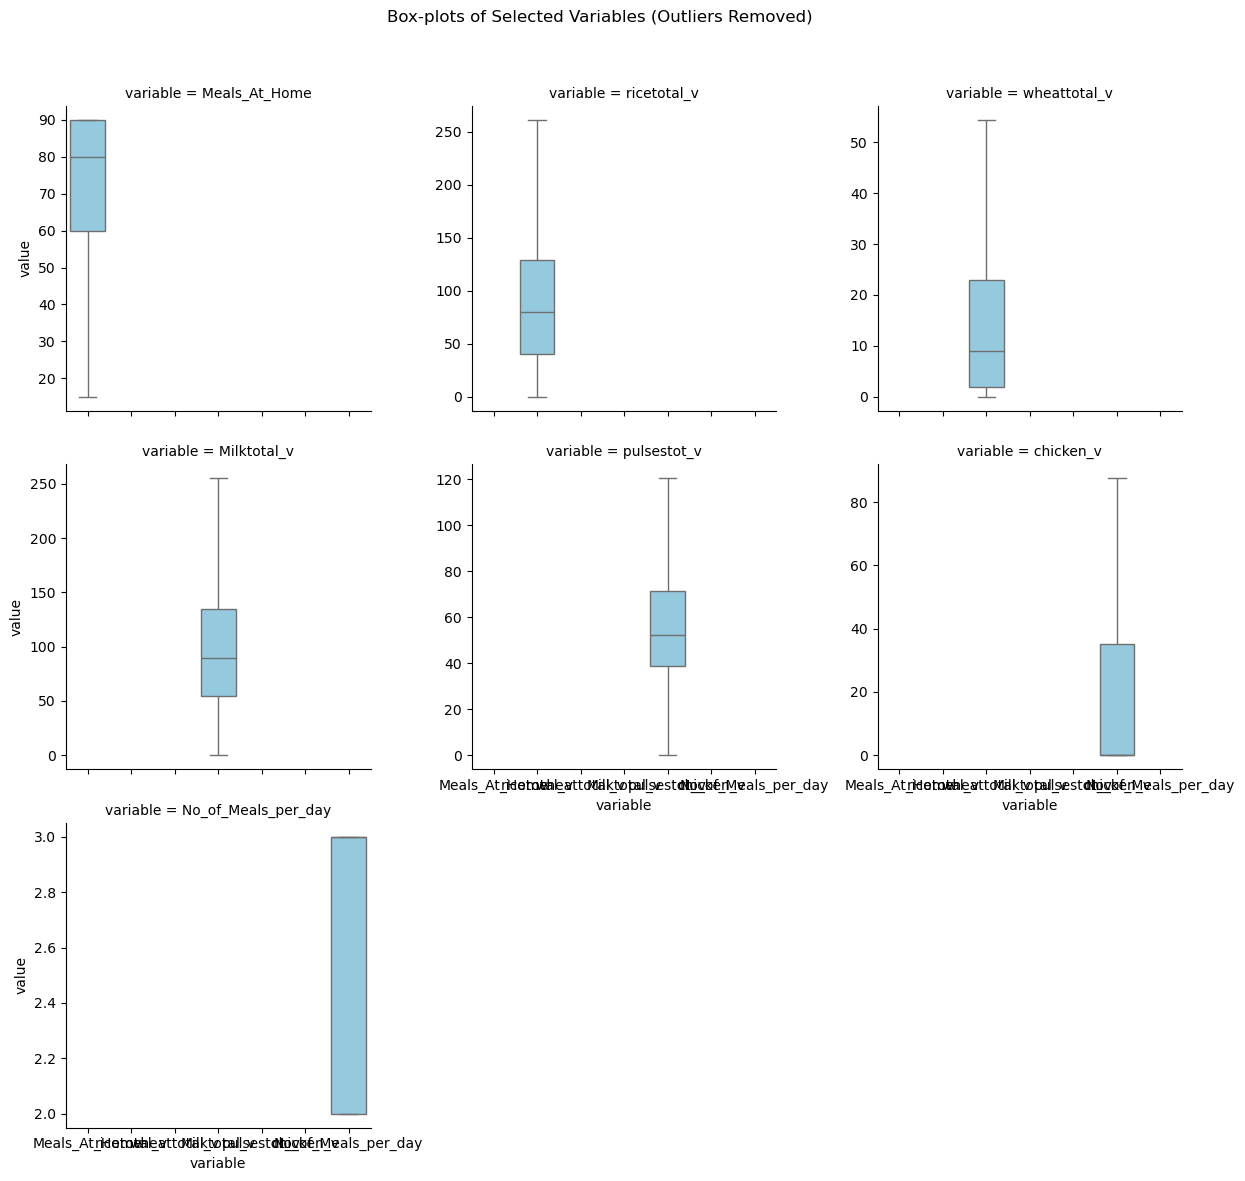

In [15]:
# 14. Box Plot ####
df_melted = state_subset_plot[boxplot_columns] \
    .melt(var_name="variable", value_name="value")

g = sns.catplot(
    x="variable", y="value", kind="box",
    data=df_melted, col="variable", col_wrap=3,
    height=4, aspect=1, sharey=False,
    color="skyblue",
    showfliers=False    # ← this hides all the little dots
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Box-plots of Selected Variables (Outliers Removed)")
plt.show()